In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import seaborn as sns
import matplotlib as mpl

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import data.constants as dc

In [4]:
collection_name = 'week16_densities_cora_ml'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [5]:
[ex for ex in experiments if len(ex['config']['data']['left_out_class_labels']) == 0][0]['result']

{'results': {'val_member_0_cross_entropy-val-0': [0.6442739367485046],
  'val_member_0_accuracy-val-0': [0.8285714387893677],
  'val_member_0_loss-val-0': [0.6442739367485046],
  'ensemble_accuracy-val-0': [0.8285714387893677],
  'accuracy_val__val': [0.8285714387893677],
  'accuracy_id_val__val': [0.8285714387893677],
  'accuracy_ood_val__val': [nan],
  'accuracy_val_no-edges_val': [0.7285714149475098],
  'accuracy_id_val_no-edges_val': [0.7285714149475098],
  'accuracy_ood_val_no-edges_val': [nan],
  'ece_val__val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.1588194572499722}],
  'ece_val_no-edges_val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.02646612280181248}],
  'auroc_feature-distance_input-ber_val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.8436957514846962}],
  'aucpr_feature-distance_input-ber_val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.8470663801104851}],
 

In [6]:
collection = seml.database.get_collection(collection_name)
experiments_unfinished = [{'config' : r['config'], 'id' : r['_id']} for r in collection.find() if r['status'] not in ('COMPLETED',)]

In [7]:
set(ex['config']['model']['use_spectral_norm'] for ex in experiments_unfinished), \
    set(ex['config']['model']['residual'] for ex in experiments_unfinished)

({False}, {True})

In [8]:
mode = 'val' # 'test'

In [9]:
METRIC = 'Metric'
AUROC = 'AUC-ROC'
AUCPR = 'AUC-PR'

SETTING = 'Setting'
HYBRID = 'Inductive'
TRANSDUCTIVE = 'Transductive'
LOC = 'Leave Out Classes'
NORMAL = 'Normal'
BERNOULLI = 'Bernoulli'
NO_EDGES = 'No Edges'
DENSITY_MODEL = 'Density Model'
EXPERIMENT = 'Experiment'

# Proxies / Density Model
STRUCTURE = 'Structure'
FEATURE_DISTANCE = 'Feature Distance'
INPUT_DISTANCE = 'Input Distance'
ENTROPY = 'Predictive Entropy'
MAX_SCORE = 'Max Score'
LOGIT_ENERGY = 'Logit Energy'
GPC = 'Gaussian Per Class'
MOG = 'Mixture of Gaussians'
NFPC = 'Normalizing Flow Per Class'
NF = 'Normalizing Flow'

# Fitting to
FIT_TO = 'Fit To'
FIT_TO_MASK = 'Labeled'
FIT_TO_ALL = 'All'
FIT_TO_CONF = 'High Confidence'

# NF types
FLOW_LAYER = 'Layer Type'
RADIAL = 'Radial'
MAF = 'MAF'
NUM_FLOW_LAYERS = 'Layers'
# aggregates info about layers
FLOW_MODEL = 'Flow Model'

# Covariance types
COVARIANCE_TYPE = 'Covariance'
FULL = 'Full'
DIAG = 'Diagonal'
ISO = 'Spherical'
EYE = 'Identity'

# Per class eval modes
PER_CLASS_MODE = 'Class Density'
WEIGHTED = 'Weighted'
MAX = 'Max'

RELATIVE = 'Background'

# MoG initializations
INITIALIZATION = 'Initialization'
RANDOM = 'Random'
PREDICTIONS = 'Predictions'

In [10]:
data = []


for ex in [ex for ex in experiments if not ex['config']['model']['residual'] and not ex['config']['model']['use_spectral_norm']]:
    cfg = ex['config']
    base = {
        SETTING : {dc.HYBRID : HYBRID, dc.TRANSDUCTIVE : TRANSDUCTIVE}[cfg['data']['setting']],
        
    }
    for k, vs in ex['metrics'].items():
        if ('auroc' in k or 'aucpr' in k) and k.endswith('_' + mode):
            if 'auroc' in k:
                metric = AUROC
                k = k.replace('auroc_', '')
            elif 'aucpr' in k:
                metric = AUCPR
                k = k.replace('aucpr_', '')
            else:
                raise ValueError(k)
            
            k = k.replace(metric + '_', '').replace('_' + mode, '')
            if '-no-edges' in k:
                no_edges = True
                k = k.replace('-no-edges', '')
            else:
                no_edges = False
                
            if '_loc' in k or '-loc' in k:
                exp = LOC
                k = k.replace('_loc', '').replace('-loc', '')
            elif '_ber' in k or '-ber' in k:
                exp = BERNOULLI
                k = k.replace('_ber', '').replace('-ber', '')
            elif '_normal' in k or '-normal' in k:
                exp = NORMAL
                k = k.replace('_normal', '').replace('-normal', '')
            else:
                raise ValueError(k)
            
            metric_cfg = {}
            
            if k == 'feature-distance_input':
                metric_cfg[DENSITY_MODEL] = INPUT_DISTANCE
            elif k == 'structure':
                metric_cfg[DENSITY_MODEL] = STRUCTURE
            elif k == 'total-predictive-entropy':
                metric_cfg[DENSITY_MODEL] = ENTROPY
            elif k == 'max-score':
                metric_cfg[DENSITY_MODEL] = MAX_SCORE
            elif k == 'logit-energy':
                metric_cfg[DENSITY_MODEL] = LOGIT_ENERGY
            else:
                # These density models can be fit to different things
                if k.endswith('_fit-mask'):
                    metric_cfg[FIT_TO] = FIT_TO_MASK
                    k = k.replace('_fit-mask', '')
                elif k.endswith('_fit-all'):
                    metric_cfg[FIT_TO] = FIT_TO_ALL
                    k = k.replace('_fit-all', '')
                elif k.endswith('_fit-95conf'):
                    metric_cfg[FIT_TO] = FIT_TO_CONF
                    k = k.replace('_fit-95conf', '')
                else:
                    raise ValueError(k)
                if k == 'feature-distance':
                    metric_cfg[DENSITY_MODEL] = FEATURE_DISTANCE
                else:
                    if not k.endswith(':no'):
                        raise ValueError(k)
                    k = k.replace(':no', '')
                    
                    if k.startswith('gpc'):
                        _, covariance, gpc_mode, relative = k.split('-')
                        metric_cfg |= {
                            COVARIANCE_TYPE : {'diag' : DIAG, 'full' : FULL, 'iso' : ISO, 'eye' : EYE}[covariance],
                            PER_CLASS_MODE : {'mode:weighted' : WEIGHTED, 'mode:max' : MAX}[gpc_mode],
                            RELATIVE : {'relative:True' : 'Relative', 'relative:False' : 'Not Relative'}[relative],
                            DENSITY_MODEL : GPC,
                        }
                    elif k.startswith('mog'):
                        _, components, covariance, initialization = k.split('-')
                        metric_cfg |= {
                            COVARIANCE_TYPE : {'diag' : DIAG, 'full' : FULL}[covariance],
                            INITIALIZATION : {'random' : RANDOM, 'predictions' : PREDICTIONS}[initialization],
                            DENSITY_MODEL : MOG,
                        }
                    elif k.startswith('nfpc'):
                        _, layers, layer_type, _, _, pc_mode, relative = k.split('-')
                        flow_layer = {'radial' : RADIAL, 'maf' : MAF}[layer_type]
                        metric_cfg |= {
                            FLOW_LAYER : flow_layer ,
                            NUM_FLOW_LAYERS : layers,
                            PER_CLASS_MODE : {'mode:weighted' : WEIGHTED, 'mode:max' : MAX}[pc_mode],
                            RELATIVE : {'relative:True' : 'Relative', 'relative:False' : 'Not Relative'}[relative],
                            DENSITY_MODEL : NFPC,
                            FLOW_MODEL : f'{layers}-{flow_layer}',
                        }
                    elif k.startswith('nf'):
                        _, layers, layer_type, _, _ = k.split('-')
                        flow_layer = {'radial' : RADIAL, 'maf' : MAF}[layer_type]
                        metric_cfg |= {
                            FLOW_LAYER : flow_layer,
                            NUM_FLOW_LAYERS : layers,
                            DENSITY_MODEL : NF,
                            FLOW_MODEL : f'{layers}-{flow_layer}',
                        }
                    else:
                        raise ValueError(k)
                
                
            for v in vs:
                v = v['value']
                data.append({
                    metric : v,
                    NO_EDGES : no_edges,
                    EXPERIMENT : exp,
                } | metric_cfg | base)




In [11]:
df = pd.DataFrame(data)

# GPC

### Inductive

[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]


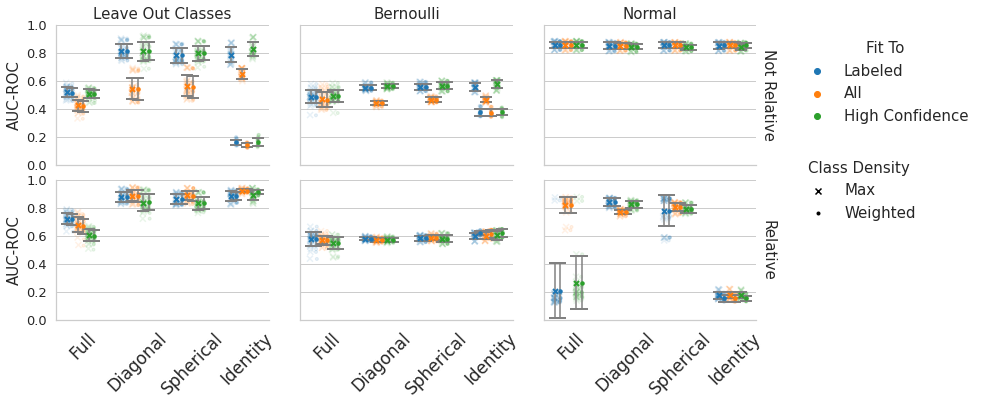

In [12]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = [FULL, DIAG, ISO, EYE]
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [MAX, WEIGHTED]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == GPC) & (df[NO_EDGES] == False) & (df[SETTING] == HYBRID)],
        col = EXPERIMENT, 
        row = RELATIVE, margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, PER_CLASS_MODE)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.065, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
    
    
plt.savefig('thesis_nbs/density_models_plots/gpc-hybrid.pdf', bbox_inches='tight')

[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]


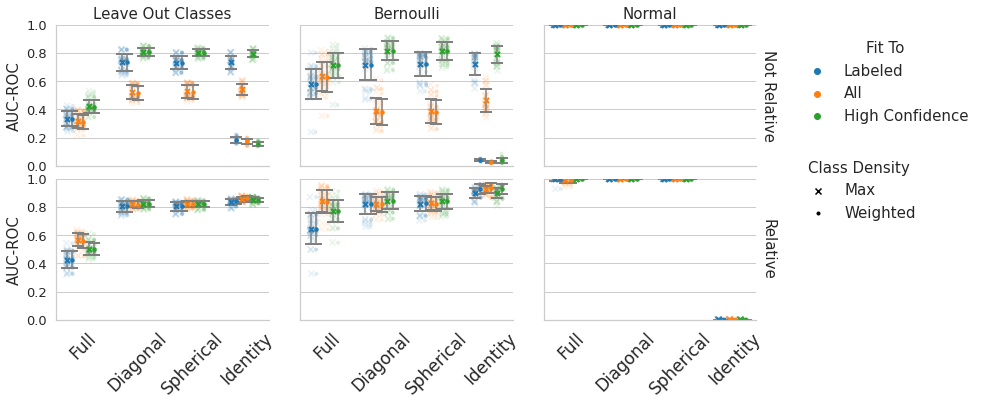

In [13]:


sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = [FULL, DIAG, ISO, EYE]
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [MAX, WEIGHTED]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == GPC) & (df[NO_EDGES] == True) & (df[SETTING] == HYBRID)],
        col = EXPERIMENT, 
        row = RELATIVE, margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, PER_CLASS_MODE)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.065, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
    
    
plt.savefig('thesis_nbs/density_models_plots/gpc-hybrid-no-edges.pdf', bbox_inches='tight')

## Transductive

[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]


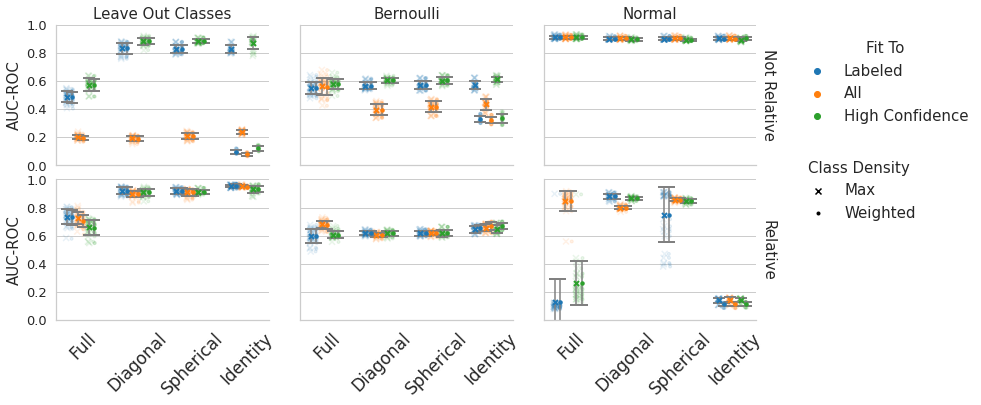

In [14]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = [FULL, DIAG, ISO, EYE]
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [MAX, WEIGHTED]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == GPC) & (df[NO_EDGES] == False) & (df[SETTING] == TRANSDUCTIVE)],
        col = EXPERIMENT, 
        row = RELATIVE, margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, PER_CLASS_MODE)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.065, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
    
plt.savefig('thesis_nbs/density_models_plots/gpc-transductive.pdf', bbox_inches='tight')

[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]
[ 3. 13. 23. 33.]


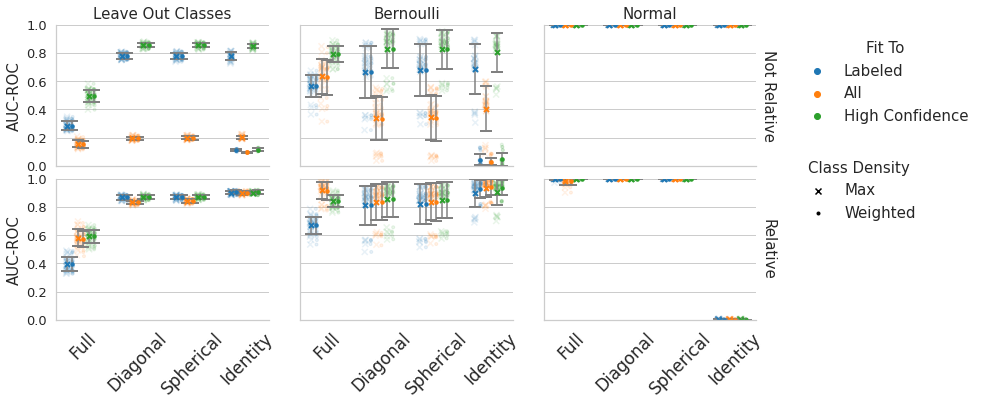

In [15]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = [FULL, DIAG, ISO, EYE]
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [MAX, WEIGHTED]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == GPC) & (df[NO_EDGES] == True) & (df[SETTING] == TRANSDUCTIVE)],
        col = EXPERIMENT, 
        row = RELATIVE, margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, PER_CLASS_MODE)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.065, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
    
plt.savefig('thesis_nbs/density_models_plots/gpc-transductive-no-edges.pdf', bbox_inches='tight')

# Normalizing Flows per Class

In [16]:
set(df[FLOW_MODEL])

{'10-MAF', '10-Radial', '16-MAF', '16-Radial', '2-MAF', '2-Radial', nan}

[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]


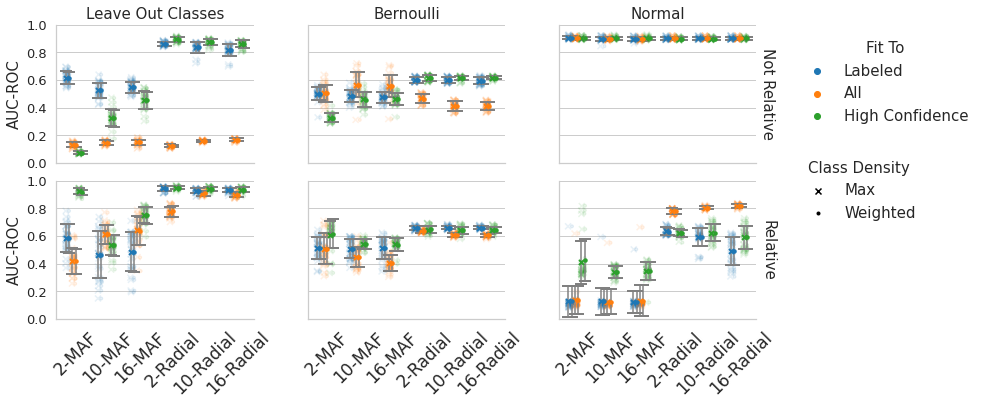

In [17]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = ['2-MAF', '10-MAF', '16-MAF', '2-Radial', '10-Radial', '16-Radial']
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [MAX, WEIGHTED]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad
    # print(order_all)    

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == NFPC) & (df[NO_EDGES] == False) & (df[SETTING] == TRANSDUCTIVE)],
        col = EXPERIMENT, 
        row = RELATIVE, margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO, PER_CLASS_MODE)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.065, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
        
plt.savefig('thesis_nbs/density_models_plots/nfpc-transductive.pdf', bbox_inches='tight')
    

[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]


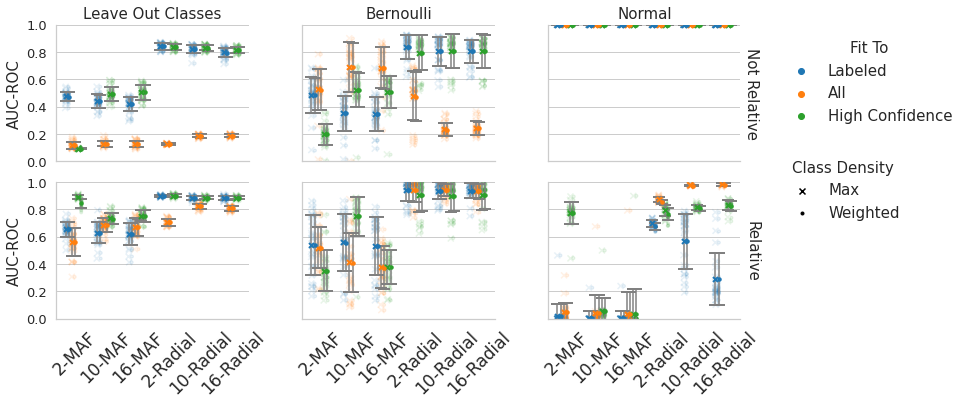

In [18]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = ['2-MAF', '10-MAF', '16-MAF', '2-Radial', '10-Radial', '16-Radial']
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [MAX, WEIGHTED]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad
    # print(order_all)    

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == NFPC) & (df[NO_EDGES] == True) & (df[SETTING] == TRANSDUCTIVE)],
        col = EXPERIMENT, 
        row = RELATIVE, margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO, PER_CLASS_MODE)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.065, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
        
plt.savefig('thesis_nbs/density_models_plots/nfpc-transductive-no-edges.pdf', bbox_inches='tight')

[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]


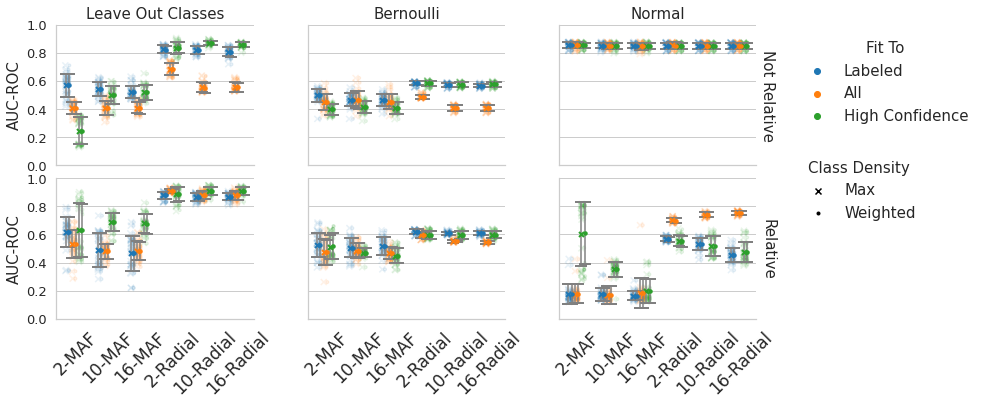

In [19]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = ['2-MAF', '10-MAF', '16-MAF', '2-Radial', '10-Radial', '16-Radial']
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [MAX, WEIGHTED]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad
    # print(order_all)    

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == NFPC) & (df[NO_EDGES] == False) & (df[SETTING] == HYBRID)],
        col = EXPERIMENT, 
        row = RELATIVE, margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO, PER_CLASS_MODE)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.065, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
        
plt.savefig('thesis_nbs/density_models_plots/nfpc-hybrid.pdf', bbox_inches='tight')

[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]
[ 3. 13. 23. 33. 43. 53.]


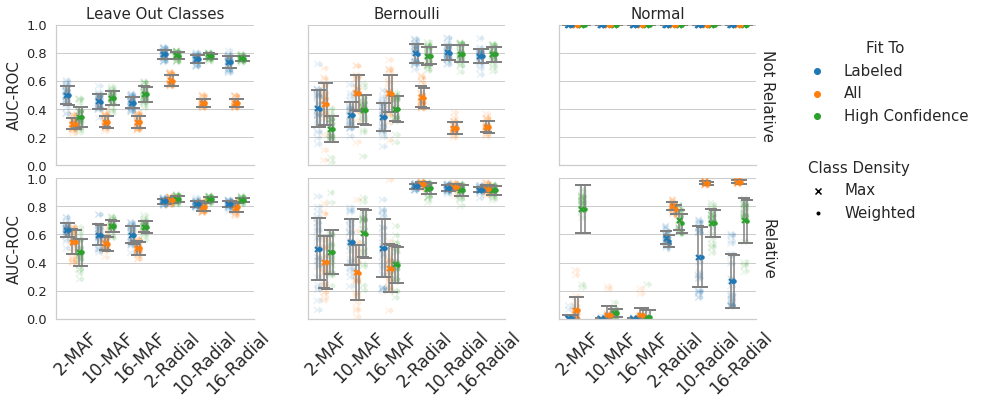

In [20]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = ['2-MAF', '10-MAF', '16-MAF', '2-Radial', '10-Radial', '16-Radial']
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [MAX, WEIGHTED]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad
    # print(order_all)    

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == NFPC) & (df[NO_EDGES] == True) & (df[SETTING] == HYBRID)],
        col = EXPERIMENT, 
        row = RELATIVE, margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO, PER_CLASS_MODE)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.065, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
        
plt.savefig('thesis_nbs/density_models_plots/nfpc-hybrid-no-edges.pdf', bbox_inches='tight')

### NF

[ 1.5  8.5 15.5 22.5 29.5 36.5]
[ 1.5  8.5 15.5 22.5 29.5 36.5]
[ 1.5  8.5 15.5 22.5 29.5 36.5]


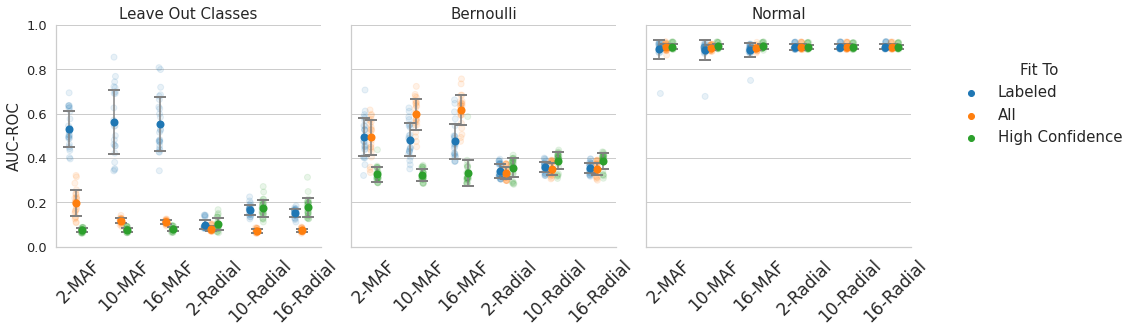

In [21]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = ['2-MAF', '10-MAF', '16-MAF', '2-Radial', '10-Radial', '16-Radial']
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            order_all.append(f'{ox}#{oh}')
        order_all += [''] * xpad
    # print(order_all)    

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == NF) & (df[NO_EDGES] == False) & (df[SETTING] == TRANSDUCTIVE)],
        col = EXPERIMENT, 
        margin_titles = True,

        height=5.0,
        aspect=0.9,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}') for x, h, in zip(x, hue,)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])


        plt.scatter(x_plot_jit[:], y[:], c = color[:], marker='o', alpha=0.1)
        # Plot means with errorbars
        for xx in np.unique(x_plot[:]):
            yy = (y[(x_plot == xx)].mean())
            err = (y[(x_plot == xx)].std())

            _cs = set(color[(x_plot == xx)])
            assert len(_cs) == 1
            c = (list(_cs)[0])
            plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt='o', ms=6, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.00, .7,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    # g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
        
plt.savefig('thesis_nbs/density_models_plots/nf-transductive.pdf', bbox_inches='tight')

[ 1.5  8.5 15.5 22.5 29.5 36.5]
[ 1.5  8.5 15.5 22.5 29.5 36.5]
[ 1.5  8.5 15.5 22.5 29.5 36.5]


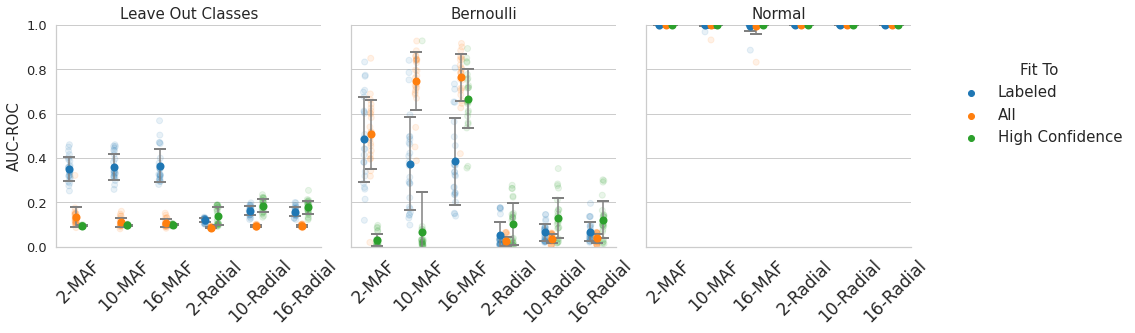

In [22]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = ['2-MAF', '10-MAF', '16-MAF', '2-Radial', '10-Radial', '16-Radial']
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            order_all.append(f'{ox}#{oh}')
        order_all += [''] * xpad
    # print(order_all)    

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == NF) & (df[NO_EDGES] == True) & (df[SETTING] == TRANSDUCTIVE)],
        col = EXPERIMENT, 
        margin_titles = True,

        height=5.0,
        aspect=0.9,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}') for x, h, in zip(x, hue,)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])


        plt.scatter(x_plot_jit[:], y[:], c = color[:], marker='o', alpha=0.1)
        # Plot means with errorbars
        for xx in np.unique(x_plot[:]):
            yy = (y[(x_plot == xx)].mean())
            err = (y[(x_plot == xx)].std())

            _cs = set(color[(x_plot == xx)])
            assert len(_cs) == 1
            c = (list(_cs)[0])
            plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt='o', ms=6, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.00, .7,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    # g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
    
plt.savefig('thesis_nbs/density_models_plots/nf-transductive-no-edges.pdf', bbox_inches='tight')

[ 1.5  8.5 15.5 22.5 29.5 36.5]
[ 1.5  8.5 15.5 22.5 29.5 36.5]
[ 1.5  8.5 15.5 22.5 29.5 36.5]


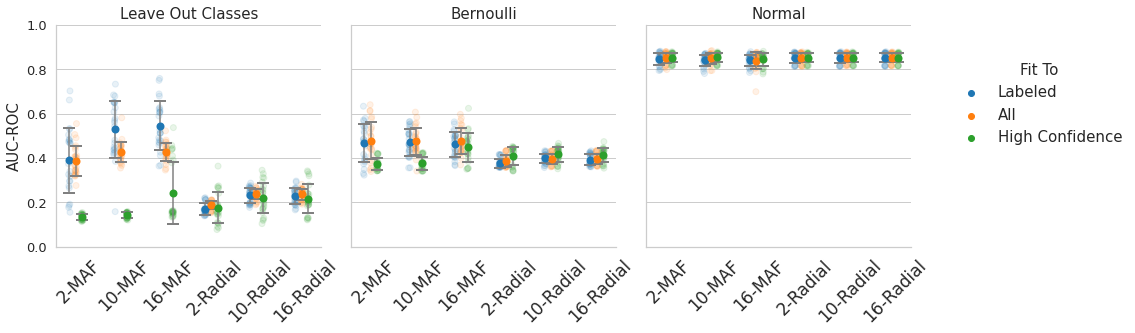

In [23]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = ['2-MAF', '10-MAF', '16-MAF', '2-Radial', '10-Radial', '16-Radial']
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            order_all.append(f'{ox}#{oh}')
        order_all += [''] * xpad
    # print(order_all)    

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == NF) & (df[NO_EDGES] == False) & (df[SETTING] == HYBRID)],
        col = EXPERIMENT, 
        margin_titles = True,

        height=5.0,
        aspect=0.9,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}') for x, h, in zip(x, hue,)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])


        plt.scatter(x_plot_jit[:], y[:], c = color[:], marker='o', alpha=0.1)
        # Plot means with errorbars
        for xx in np.unique(x_plot[:]):
            yy = (y[(x_plot == xx)].mean())
            err = (y[(x_plot == xx)].std())

            _cs = set(color[(x_plot == xx)])
            assert len(_cs) == 1
            c = (list(_cs)[0])
            plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt='o', ms=6, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.00, .7,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    # g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
    
plt.savefig('thesis_nbs/density_models_plots/nf-hybrid.pdf', bbox_inches='tight')

[ 1.5  8.5 15.5 22.5 29.5 36.5]
[ 1.5  8.5 15.5 22.5 29.5 36.5]
[ 1.5  8.5 15.5 22.5 29.5 36.5]


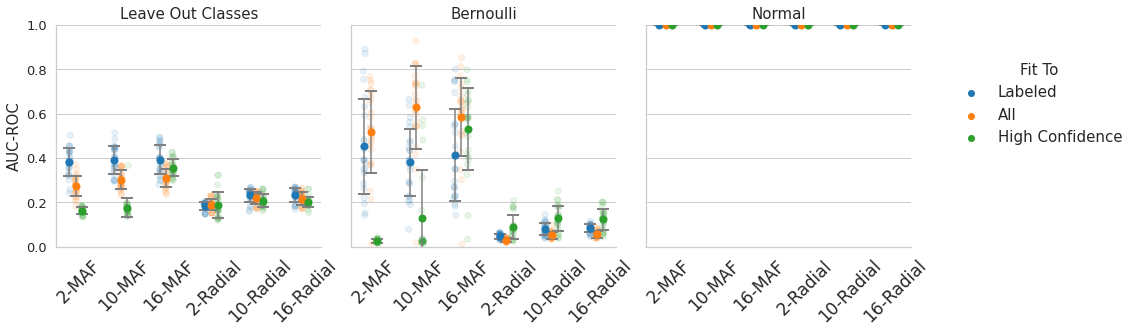

In [24]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = ['2-MAF', '10-MAF', '16-MAF', '2-Radial', '10-Radial', '16-Radial']
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            order_all.append(f'{ox}#{oh}')
        order_all += [''] * xpad
    # print(order_all)    

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == NF) & (df[NO_EDGES] == True) & (df[SETTING] == HYBRID)],
        col = EXPERIMENT, 
        margin_titles = True,

        height=5.0,
        aspect=0.9,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}') for x, h, in zip(x, hue,)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])


        plt.scatter(x_plot_jit[:], y[:], c = color[:], marker='o', alpha=0.1)
        # Plot means with errorbars
        for xx in np.unique(x_plot[:]):
            yy = (y[(x_plot == xx)].mean())
            err = (y[(x_plot == xx)].std())

            _cs = set(color[(x_plot == xx)])
            assert len(_cs) == 1
            c = (list(_cs)[0])
            plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt='o', ms=6, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=45, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, FLOW_MODEL, AUROC, FIT_TO)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.00, .7,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    # g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .55,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
        
plt.savefig('thesis_nbs/density_models_plots/nf-hybrid-no-edges.pdf', bbox_inches='tight')

## MoG

[ 3. 13.]
[ 3. 13.]
[ 3. 13.]


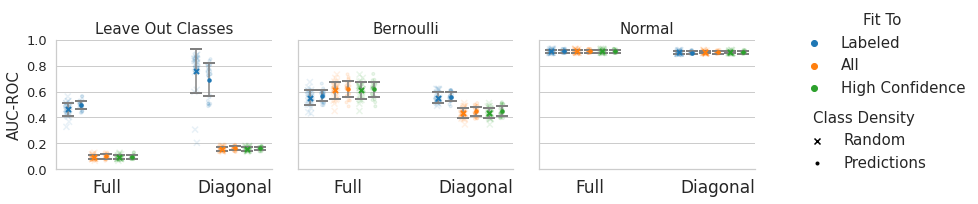

In [25]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = [FULL, DIAG]
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [RANDOM, PREDICTIONS]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == MOG) & (df[NO_EDGES] == False) & (df[SETTING] == TRANSDUCTIVE)],
        col = EXPERIMENT,
        margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=0, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, INITIALIZATION)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.05, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .4,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)

plt.savefig('thesis_nbs/density_models_plots/mog-transductive.pdf', bbox_inches='tight')

[ 3. 13.]
[ 3. 13.]
[ 3. 13.]


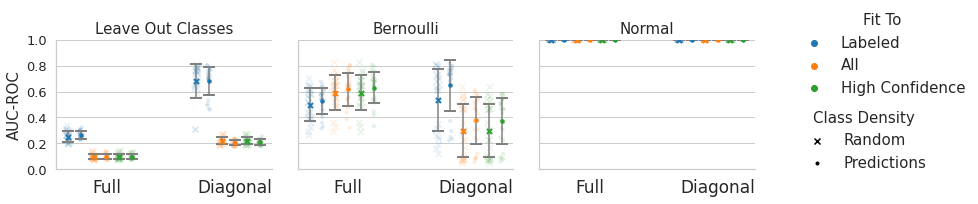

In [26]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = [FULL, DIAG]
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [RANDOM, PREDICTIONS]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == MOG) & (df[NO_EDGES] == True) & (df[SETTING] == TRANSDUCTIVE)],
        col = EXPERIMENT,
        margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=0, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, INITIALIZATION)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.05, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .4,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
plt.savefig('thesis_nbs/density_models_plots/mog-transductive-no-edges.pdf', bbox_inches='tight')

[ 3. 13.]
[ 3. 13.]
[ 3. 13.]


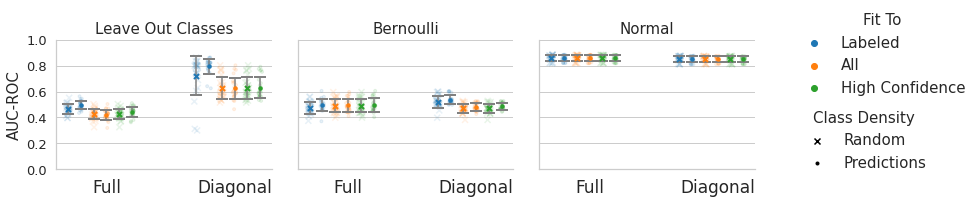

In [27]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = [FULL, DIAG]
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [RANDOM, PREDICTIONS]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == MOG) & (df[NO_EDGES] == False) & (df[SETTING] == HYBRID)],
        col = EXPERIMENT,
        margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=0, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, INITIALIZATION)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.05, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .4,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)

plt.savefig('thesis_nbs/density_models_plots/mog-hybrid.pdf', bbox_inches='tight')

[ 3. 13.]
[ 3. 13.]
[ 3. 13.]


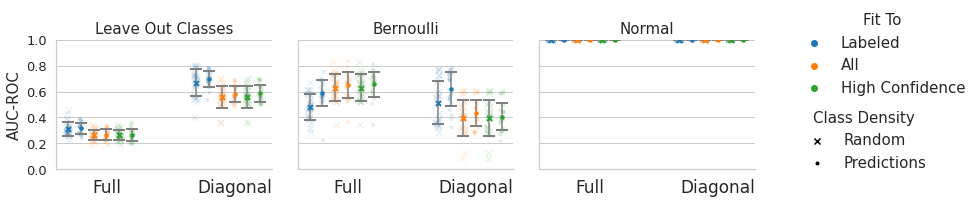

In [28]:

sns.set(font_scale=1.0)  # crazy big
with sns.axes_style("whitegrid"):

    # Extremely hacky plotting...
    order_x = [FULL, DIAG]
    order_hue = [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF]
    order_style = [RANDOM, PREDICTIONS]

    xpad = 4
    
    order_all = []
    for ox in order_x:
        for oh in order_hue:
            for os in order_style:
                order_all.append(f'{ox}#{oh}#{os}')
        order_all += [''] * xpad

    hue_colors = ['tab:blue', 'tab:orange', 'tab:green']
    styles = ['x', '.']

    g = sns.FacetGrid(
        data = df[(df[DENSITY_MODEL] == MOG) & (df[NO_EDGES] == True) & (df[SETTING] == HYBRID)],
        col = EXPERIMENT,
        margin_titles = True,

        height=3.0,
        aspect=1.0,
    )

    artists_hue = {}
    artists_style = {}

    def plot_y(x, y, hue, st, color=None, label=None):

        x_plot = np.array([order_all.index(f'{x}#{h}#{s}') for x, h, s in zip(x, hue, st)], dtype=float)
        # jitter
        x_plot_jit = x_plot + ((0.5 - np.random.rand(x_plot.shape[0])) * 0.3)
        color = np.array([hue_colors[order_hue.index(h)] for h in hue])

        for sidx, s in enumerate(order_style):
            plt.scatter(x_plot_jit[st == s], y[st == s], c = color[st == s], marker=styles[sidx], alpha=0.1)
            # Plot means with errorbars
            for xx in np.unique(x_plot[st == s]):
                yy = (y[(st == s) & (x_plot == xx)].mean())
                err = (y[(st == s) & (x_plot == xx)].std())

                _cs = set(color[(st == s) & (x_plot == xx)])
                assert len(_cs) == 1
                c = (list(_cs)[0])
                plt.errorbar([xx], [yy], [err], ecolor='grey', mew=2, fmt=styles[sidx], ms=5, capsize=6, c=c)

        # Add empty artists for legends
        for h, color in zip(order_hue, hue_colors):
            artists_hue[h] = plt.scatter([], [], marker='o', c=color)
        for s, marker in zip(order_style, styles):
            artists_style[s] = plt.scatter([], [], c='black', marker=marker)


        width = (len(order_all) / (len(order_x))) - xpad
        
        centers = (np.arange(len(order_x)) * (width + xpad)) + (width / 2)

        print(centers)
        plt.xticks(ticks=centers, labels=order_x, rotation=0, size=17)
        plt.yticks(size=13)
        return



        sns.stripplot(x=x, y=y, color=color, hue=color, label=label, alpha=0.1, order=order)
        # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
        # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
        #               jitter=False, marker='X', edgecolor='black', linewidth=0)
        _x, _y, _yerr = [], [], []
        for idx, xx in enumerate(order):
            _x.append(idx)
            _y.append(y[x == xx].mean())
            _yerr.append(y[x == xx].std())

        artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=8, capsize=6, label=label))

    g.map(plot_y, COVARIANCE_TYPE, AUROC, FIT_TO, INITIALIZATION)
    mpl.rcParams['legend.title_fontsize'] = 15
    g.add_legend(artists_hue, title=FIT_TO, bbox_to_anchor=(1.05, .8,), fontsize=15, adjust_subtitles=True, title_fontsize=24)
    g.add_legend(artists_style, title=PER_CLASS_MODE, bbox_to_anchor=(1.01, .4,), adjust_subtitles=True, fontsize=15)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
    g.set_ylabels('AUC-ROC', size=15)
    # g.set_xlabels('Covariance Type', size=17)
    g.set_xlabels('', size=15)
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_ylim(0, 1)
        
plt.savefig('thesis_nbs/density_models_plots/mog-hybrid-no-edges.pdf', bbox_inches='tight')